In [4]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, GlobalAveragePooling2D, Embedding, LSTM, Bidirectional, Concatenate, Flatten, Dropout
)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from gensim.models import Word2Vec

In [5]:
IMG_SIZE = (224, 224)
MAX_SEQ_LENGTH = 1000
VOCAB_SIZE = 50000
EMBEDDING_DIM = 100
BATCH_SIZE = 32

In [6]:
train_data = pd.read_csv("C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Split Dataset\\Training_meme_dataset.csv")
val_data = pd.read_csv("C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Split Dataset\\Validation_meme_dataset.csv")
test_data = pd.read_csv("C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\MultiOFF_Dataset\\Split Dataset\\Testing_meme_dataset.csv")

In [7]:
# Preprocess Labels
label_encoder = LabelEncoder()
train_data["label"] = label_encoder.fit_transform(train_data["label"])
val_data["label"] = label_encoder.transform(val_data["label"])
test_data["label"] = label_encoder.transform(test_data["label"])

In [34]:
def preprocess_images_inresv2(image_dir, image_list):
    images = []
    for img_name in image_list:
        img_path = os.path.join(image_dir, img_name)
        img = load_img(img_path, target_size=(299, 299))  # Resize image to fit InceptionV3 input size
        img_array = img_to_array(img)  # Convert image to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = tf.keras.applications.inception_resnet_v2.preprocess_input(img_array)  # InceptionV3 preprocessing
        images.append(img_array)
    return np.vstack(images)

In [35]:
train_images = preprocess_images_inresv2("C:/Users/jasra/OneDrive/Desktop/MAJOR PROJECT/MultiOFF_Dataset/Labelled Images/", train_data["image_name"])
val_images = preprocess_images_inresv2("C:/Users/jasra/OneDrive/Desktop/MAJOR PROJECT/MultiOFF_Dataset/Labelled Images/", val_data["image_name"])
test_images = preprocess_images_inresv2("C:/Users/jasra/OneDrive/Desktop/MAJOR PROJECT/MultiOFF_Dataset/Labelled Images/", test_data["image_name"])

In [8]:
import re
from nltk.corpus import stopwords
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
EMAIL = re.compile(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}')
NUMBERS_RE = re.compile(r'\d+')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):  #preprocessing of text 
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower()
    text = EMAIL.sub('', text)
    text = NUMBERS_RE.sub('', text)  # Remove numbers
    text = REPLACE_BY_SPACE_RE.sub(' ',text)
    text = BAD_SYMBOLS_RE.sub('',text)    
    # text = text.replace('x','')
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    
    return text

In [9]:
train_data['sentence'] = train_data['sentence'].apply(clean_text)
test_data['sentence'] = test_data['sentence'].apply(clean_text)
val_data['sentence'] = val_data['sentence'].apply(clean_text)

In [15]:
max_words = 50000  # Vocabulary size
max_len = 1000  # Maximum sequence length
embedding_dim = 300  # Embedding dimension

In [16]:
def load_glove_embeddings(filepath, word_index, embedding_dim):
    embeddings_index = {}
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddings_index[word] = np.asarray(values[1:], dtype='float32')

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [17]:
# Preprocess Text
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data["sentence"])
word_index = tokenizer.word_index

In [18]:
train_text = pad_sequences(tokenizer.texts_to_sequences(train_data["sentence"]), maxlen=MAX_SEQ_LENGTH)
val_text = pad_sequences(tokenizer.texts_to_sequences(val_data["sentence"]), maxlen=MAX_SEQ_LENGTH)
test_text = pad_sequences(tokenizer.texts_to_sequences(test_data["sentence"]), maxlen=MAX_SEQ_LENGTH)

In [19]:
glove_path = "C:\\Users\\jasra\\OneDrive\\Desktop\\MAJOR PROJECT\\glove.6B\\glove.6B.300d.txt"  # Update this path
embedding_matrix = load_glove_embeddings(glove_path, word_index, embedding_dim)

In [11]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the layers of InceptionResNetV2
# for layer in base_model.layers:
#     layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # To reduce the dimensions
x = Dense(128, activation='relu')(x)  # Dense layer for classification
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(1, activation='sigmoid')(x)  # Final binary classification layer

# Final model
model = Model(inputs=base_model.input, outputs=x)

219055592/219055592 [==============================] - 15s 0us/step


In [12]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_2 (BatchNo  (None, 147, 147, 64  192        ['conv2d_2[0][0]']               
 rmalization)                   )                                                                 
                                                                                                  
 activation_2 (Activation)      (None, 147, 147, 64  0           ['batch_normalization_2[0][0]']  
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 73, 73, 64)   0           ['activation_2[0][0]']           
                                                                                                  
 conv2d_3 (Conv2D)              (None, 73, 73, 80)   5120        ['max_pooling2d[0][0]']          
                                                                                                  
 batch_nor

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
image_history = model.fit(
    train_images, 
    train_data["label"], 
    validation_data=(val_images, val_data["label"]), 
    epochs=4, 
    batch_size=12,
    callbacks=[early_stopping]
)

Epoch 1/4
38/38 [==============================] - 329s 8s/step - loss: 0.7732 - accuracy: 0.5146 - val_loss: 0.7035 - val_accuracy: 0.5369
Epoch 2/4
38/38 [==============================] - 298s 8s/step - loss: 0.7054 - accuracy: 0.5820 - val_loss: 2.6703 - val_accuracy: 0.4295
Epoch 3/4
38/38 [==============================] - 317s 8s/step - loss: 0.6861 - accuracy: 0.5753 - val_loss: 14.9443 - val_accuracy: 0.6107
Epoch 4/4
38/38 [==============================] - 314s 8s/step - loss: 0.6838 - accuracy: 0.6000 - val_loss: 0.7067 - val_accuracy: 0.6107


5/5 [==============================] - 18s 3s/step


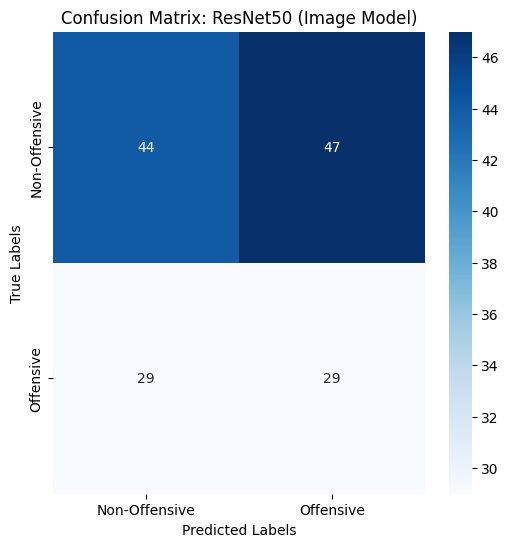

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

image_predictions = model.predict(test_images)
image_predictions_binary = (image_predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Compute Confusion Matrix
image_conf_matrix = confusion_matrix(test_data["label"], image_predictions_binary)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(image_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Offensive", "Offensive"], yticklabels=["Non-Offensive", "Offensive"])
plt.title("Confusion Matrix: ResNet50 (Image Model)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [16]:
model.save("image_model_inception-resnet.h5")

In [21]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

text_input = Input(shape=(MAX_SEQ_LENGTH,))
embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)(text_input)
x = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)
x = Dropout(0.5,name = "Dropoutt_12")(x)
x = Bidirectional(LSTM(128))(x)
x = Dense(64, activation="relu")(x)
text_output = Dense(1, activation="sigmoid")(x)  # Binary classification
text_model = Model(inputs=text_input, outputs=text_output)

# Compile Text Model
text_model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])


In [22]:
text_history = text_model.fit(
    train_text, 
    train_data["label"], 
    validation_data=(val_text, val_data["label"]), 
    epochs=7, 
    batch_size=32
)

Epoch 1/7
14/14 [==============================] - 81s 5s/step - loss: 0.6900 - accuracy: 0.5573 - val_loss: 0.6838 - val_accuracy: 0.5973
Epoch 2/7
14/14 [==============================] - 83s 6s/step - loss: 0.6559 - accuracy: 0.6135 - val_loss: 0.6586 - val_accuracy: 0.6376
Epoch 3/7
14/14 [==============================] - 83s 6s/step - loss: 0.5983 - accuracy: 0.6989 - val_loss: 0.7080 - val_accuracy: 0.5503
Epoch 4/7
14/14 [==============================] - 85s 6s/step - loss: 0.4928 - accuracy: 0.7753 - val_loss: 0.7638 - val_accuracy: 0.5570
Epoch 5/7
14/14 [==============================] - 76s 6s/step - loss: 0.3740 - accuracy: 0.8517 - val_loss: 1.0203 - val_accuracy: 0.5302
Epoch 6/7
14/14 [==============================] - 82s 6s/step - loss: 0.2913 - accuracy: 0.8697 - val_loss: 1.0662 - val_accuracy: 0.6040
Epoch 7/7
14/14 [==============================] - 81s 6s/step - loss: 0.2228 - accuracy: 0.9101 - val_loss: 0.9614 - val_accuracy: 0.5436


5/5 [==============================] - 4s 783ms/step


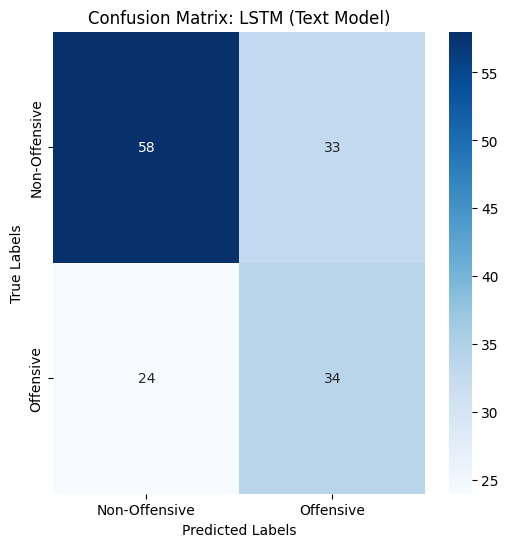

Classification Report for LSTM:
               precision    recall  f1-score   support

Non-Offensive       0.71      0.64      0.67        91
    Offensive       0.51      0.59      0.54        58

     accuracy                           0.62       149
    macro avg       0.61      0.61      0.61       149
 weighted avg       0.63      0.62      0.62       149



In [24]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict with the LSTM model
text_predictions = text_model.predict(test_text)
text_predictions_binary = (text_predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Compute Confusion Matrix
text_conf_matrix = confusion_matrix(test_data["label"], text_predictions_binary)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(text_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Offensive", "Offensive"], yticklabels=["Non-Offensive", "Offensive"])
plt.title("Confusion Matrix: LSTM (Text Model)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("Classification Report for LSTM:")
print(classification_report(test_data["label"], text_predictions_binary, target_names=["Non-Offensive", "Offensive"]))


In [25]:
text_model.save("text_glove_model_62ac.h5")

In [26]:
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Concatenate

# Load Pretrained Models
pretrained_image_model = load_model("image_model_inception-resnet.h5")
pretrained_text_model = load_model("text_glove_model_62ac.h5")

In [27]:
# Freeze the Pretrained Models
for layer in pretrained_image_model.layers:
    layer.trainable = False
for layer in pretrained_text_model.layers:
    layer.trainable = False

In [30]:
# Combine Models
image_features = pretrained_image_model.get_layer("dense_1").output  # Adjust the layer name if necessary
text_features = pretrained_text_model.get_layer("dense_3").output  # Adjust the layer name if necessary

In [31]:
combined_features = Concatenate()([image_features, text_features])
x = Dense(128, activation="relu")(combined_features)
x = Dropout(0.5, name="dropoutt_10")(x)
x = Dense(64, activation="relu")(x)
final_output = Dense(1, activation="sigmoid")(x)

# Final Multimodal Model
final_model = Model(inputs=[pretrained_image_model.input, pretrained_text_model.input], outputs=final_output)



In [32]:
# Compile Final Model
final_model.compile(optimizer=Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])


In [36]:
# Train Final Model
final_history = final_model.fit(
    [train_images, train_text],
    train_data["label"],
    validation_data=([val_images, val_text], val_data["label"]),
    epochs=7,
    batch_size=12
)

Epoch 1/7
38/38 [==============================] - 108s 3s/step - loss: 0.6788 - accuracy: 0.4854 - val_loss: 0.7041 - val_accuracy: 0.3893
Epoch 2/7
38/38 [==============================] - 86s 2s/step - loss: 0.6591 - accuracy: 0.6225 - val_loss: 0.7043 - val_accuracy: 0.4966
Epoch 3/7
38/38 [==============================] - 89s 2s/step - loss: 0.6428 - accuracy: 0.7236 - val_loss: 0.7040 - val_accuracy: 0.5302
Epoch 4/7
38/38 [==============================] - 84s 2s/step - loss: 0.6251 - accuracy: 0.8112 - val_loss: 0.7054 - val_accuracy: 0.5168
Epoch 5/7
38/38 [==============================] - 83s 2s/step - loss: 0.5960 - accuracy: 0.8629 - val_loss: 0.7080 - val_accuracy: 0.5235
Epoch 6/7
38/38 [==============================] - 86s 2s/step - loss: 0.5765 - accuracy: 0.8854 - val_loss: 0.7097 - val_accuracy: 0.5436
Epoch 7/7
38/38 [==============================] - 88s 2s/step - loss: 0.5492 - accuracy: 0.9034 - val_loss: 0.7111 - val_accuracy: 0.5503


5/5 [==============================] - 22s 4s/step


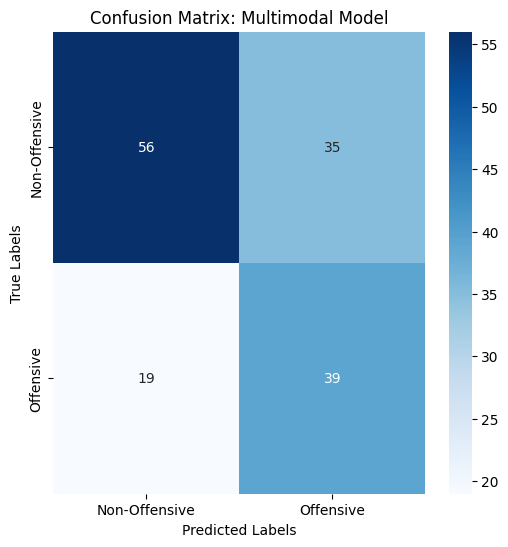

Classification Report for Multimodal Model:
               precision    recall  f1-score   support

Non-Offensive       0.75      0.62      0.67        91
    Offensive       0.53      0.67      0.59        58

     accuracy                           0.64       149
    macro avg       0.64      0.64      0.63       149
 weighted avg       0.66      0.64      0.64       149



In [37]:
# Predict with the Multimodal Model
final_predictions = final_model.predict([test_images, test_text])
final_predictions_binary = (final_predictions > 0.5).astype(int)  # Convert probabilities to 0 or 1

# Compute Confusion Matrix
final_conf_matrix = confusion_matrix(test_data["label"], final_predictions_binary)

# Visualize Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(final_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Offensive", "Offensive"], yticklabels=["Non-Offensive", "Offensive"])
plt.title("Confusion Matrix: Multimodal Model")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
print("Classification Report for Multimodal Model:")
print(classification_report(test_data["label"], final_predictions_binary, target_names=["Non-Offensive", "Offensive"]))


In [38]:
final_model.save("final_model_glove_ac64.h5")

In [39]:
test_loss, test_accuracy = final_model.evaluate([test_images, test_text], test_data["label"])
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

5/5 [==============================] - 19s 4s/step - loss: 0.6651 - accuracy: 0.6376
Test Loss: 0.6651, Test Accuracy: 0.6376


5/5 [==============================] - 21s 4s/step


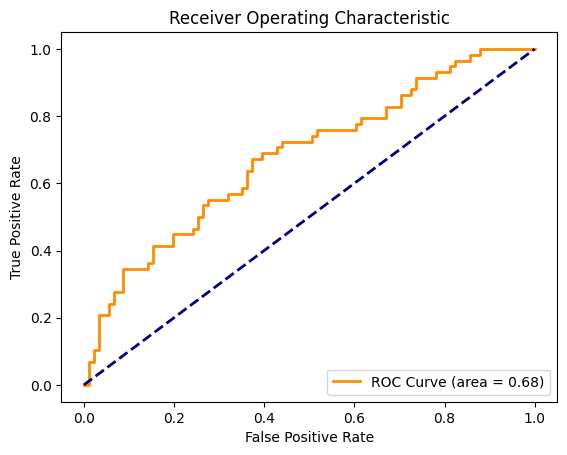

In [40]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

predictions = final_model.predict([test_images, test_text])
predicted_labels = np.where(predictions > 0.5, 1, 0)  # Assuming binary classification

fpr, tpr, _ = roc_curve(test_data["label"], predictions)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

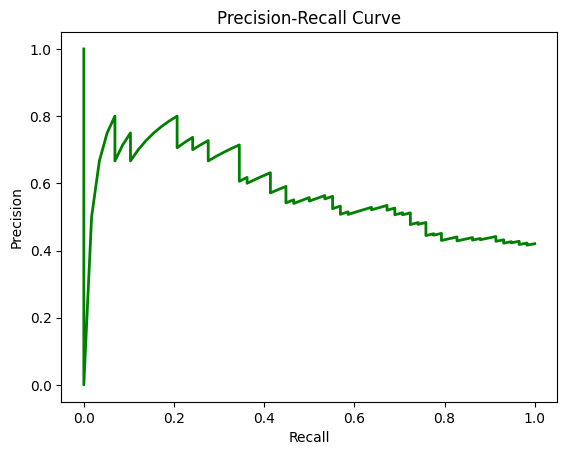

In [41]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(test_data["label"], predictions)

plt.figure()
plt.plot(recall, precision, lw=2, color='green')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()